In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Data download

In [2]:
cvegeo = '08019'

#08019 - Chihuahua
#08038 y 08045 - Julimes + Meoqui
#08051 - Ocampo

In [3]:
# Creates empty GeoDataFrame to store specified municipality polygons and hex grid
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()        

<Axes: >

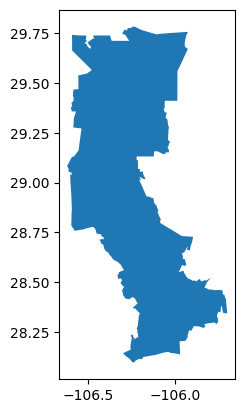

In [5]:
#Query municipalities
mun_schema = 'marco'
mun_table = 'mpos_2020'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

#Define projections and plot
mun_gdf = mun_gdf.set_crs("EPSG:4326")
mun_gdf.plot()

In [13]:
#Load points of interest and filter for relevant data
pois = gpd.read_file("../../../data/external/temporal_todocker/prueba_pois.gpkg")
points = pois[['TIPO','geometry']]

In [14]:
points.head()

,TIPO,geometry
0,Tanque Elevado,POINT (-105.96279 28.73187)
1,Tanque Elevado,POINT (-105.97175 28.76084)
2,Tanque Elevado,POINT (-105.96671 28.77223)
3,Tanque Elevado,POINT (-106.00706 28.80750)
4,Tanque Elevado,POINT (-105.87540 28.60919)


## Data treatment

### Data treatment - Create network

In [7]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

In [15]:
points = points.set_crs("EPSG:4326")
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

### Data treatment - Find nearest node for each point

In [ ]:
nearest = aup.find_nearest(G, nodes, points, return_distance= True)
nearest = nearest.set_crs("EPSG:4326")

### Data treatment - Create edges_speed network for distance_nearest_poi analysis

In [9]:
_, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx', edges_folder='edges_speed')